In [3]:
# import basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import self-defined modules
from implementations import *
from tools import *
from helpers import *

# just to ingore warning
import warnings
warnings.filterwarnings('ignore')

# Models Training

## 1. Load Training Data

In [36]:
# load train and test data
data_path_tr = 'data/train.csv'
yb_tr, data_tr, idx_tr, labels = load_csv_data(data_path_tr, sub_sample=False)

# prepare the data using self-defined DataFrame class
labels_dataframe = ['Prediction'] + labels
data_tr_dataframe = np.concatenate((yb_tr.reshape([-1, 1]), data_tr), axis=1)
dataframe_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)

## 2. Data Analysis and Pre-processing

### 2.1 Replace Missing Values with mode 

As described in the document, we know that there are '-999' referring to missing or undefined data. Before further processing, we need to deal with these abnormal data.

What's worth noticing is that there are 10 features related to the value of jet_num. If jet_num = 0 or 1, these features will be undefined and we do not need to replace -999 in these features. Then, we need to find columns with missing data and replace the missing values with mode of the feature.

So, at first we should calculate missing rate in each feature to find out the columns that need to be replaced.

In [37]:
# calculate missing rate 
def missing_rate(dataframe, miss_number = -999):
    features = dataframe.drop(['Prediction'])
    missing_rate = []
    for feature in features.labels:
        data = features.loc(features[feature] ==  miss_number)
        if data.values.size != 0:
            missing_rate.append(data[feature].size / features[feature].size)
        else:
            missing_rate.append(0)
    missing_rate = np.array(missing_rate).reshape([1, -1]).squeeze()
    missing_rate_labels = dataframe.labels[1:]
    return DataFrame(missing_rate, [0], missing_rate_labels)

In [40]:
miss_rate = missing_rate(dataframe_tr)
miss_rate.values

array([0.152456, 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.399652,
       0.399652, 0.399652, 0.709828, 0.709828, 0.709828, 0.      ])

In [41]:
miss_rate.labels[0]

'DER_mass_MMC'

There are 11 features with -999 and 10 of them have very high missing rate. According to the Higgs Boson document, we can know that the high missing rate of these 10 features are due to values of jet_num, and they are not defined on -999 and should not be replaced. 

So now there is only one feature 'DER_mass_MMC' left to be replaced. 

In [5]:
# # calculate mode of 'DER_mass_MMC' in signal
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==1)
# DER_mode_s = temp.value_counts('DER_mass_MMC').index[0]

# # calculate mode of 'DER_mass_MMC' in background
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==-1)
# DER_mode_b = temp.value_counts('DER_mass_MMC').index[0]      

DER_mode_s =119.89
DER_mode_b =96.819

# replace -999（undefined values of 'DER_mass_MMC'） with mode respectively
temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_s

temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==-1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_b

### 2.2 Drop features by histogram

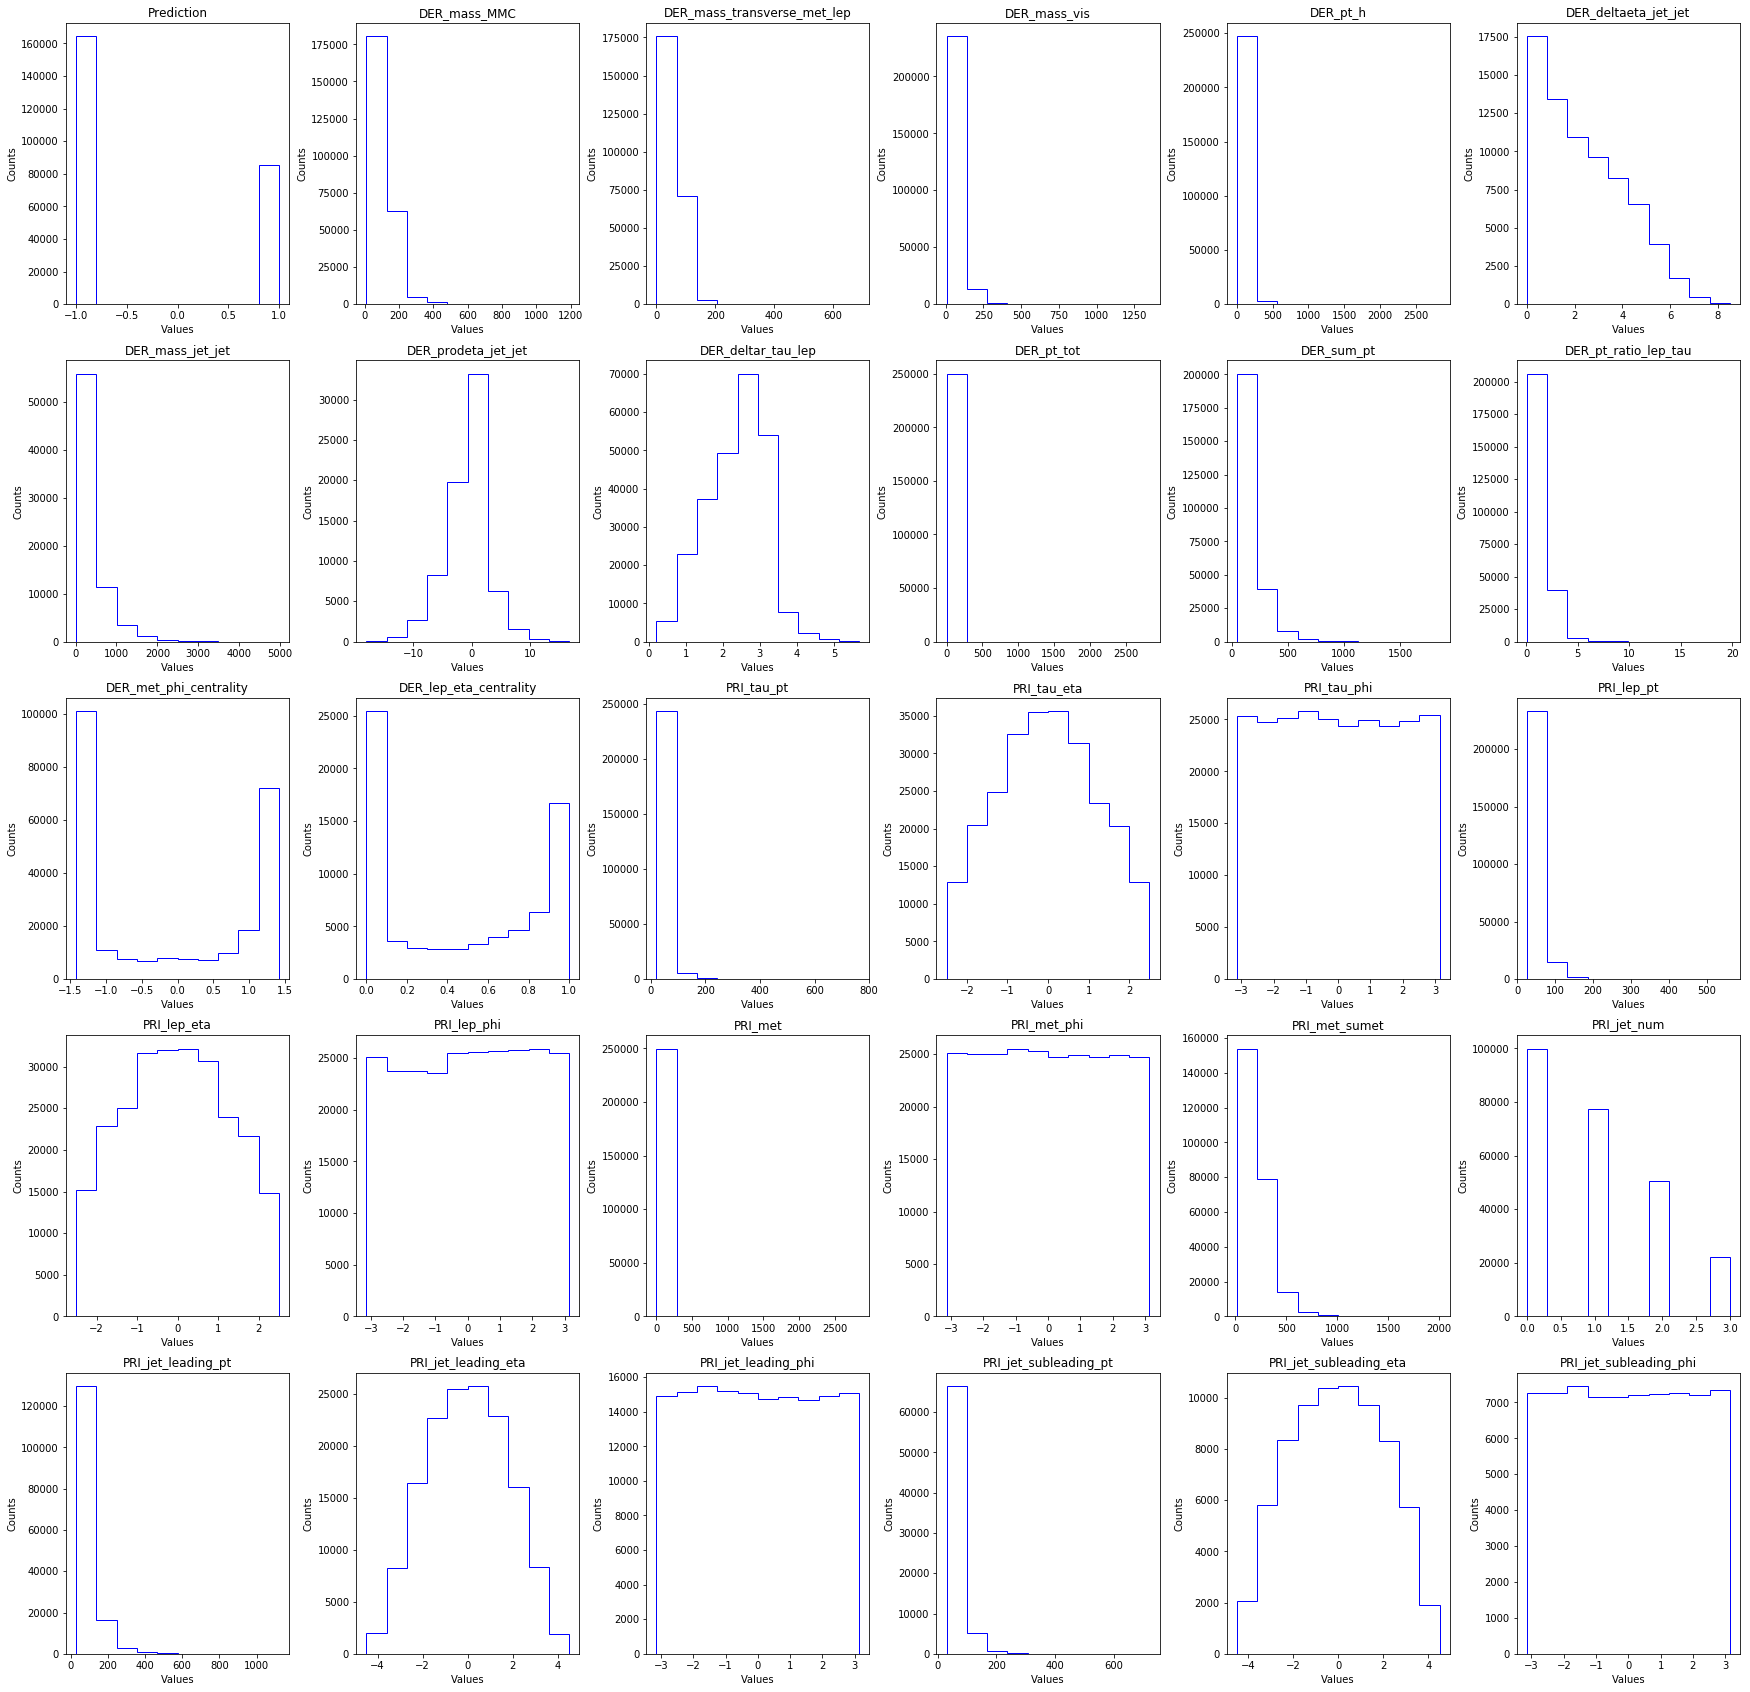

In [6]:
# plot histogram of each feature
figure, axes = plt.subplots(5, 6, facecolor='white', figsize=(30, 30))
figure.subplots_adjust(wspace=0.3)
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr.values[:, index]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype='step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(dataframe_tr.labels[index])

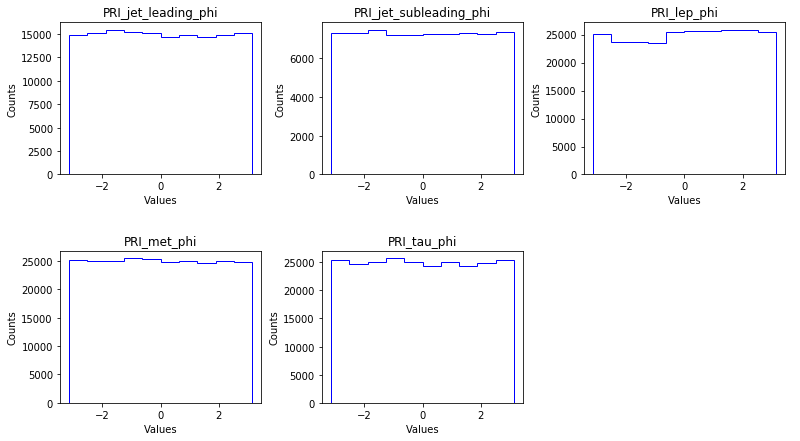

In [7]:
# drop features which are uniformly distributed
feature_dorp_phi = ['PRI_jet_leading_phi',
                    'PRI_jet_subleading_phi',
                    'PRI_lep_phi',
                    'PRI_met_phi',
                    'PRI_tau_phi']

# figure, axes = plt.subplots(2, round(len(feature_dorp_phi)/2), facecolor='white', figsize=(30, 7))
figure, axes = plt.subplots(2, 3, facecolor='white', figsize=(13, 7))
axes = axes.ravel()
figure.subplots_adjust(hspace=0.5)
figure.subplots_adjust(wspace=0.3)
for index, axes_index in enumerate(axes):
    if index < 5:
        column = dataframe_tr[feature_dorp_phi[index]]
        plot_data = column[np.where(column!=-999)]
        axes_index.hist(plot_data, histtype= 'step', color='b')
        axes_index.set_xlabel('Values')
        axes_index.set_ylabel('Counts')
        axes_index.set_title(feature_dorp_phi[index])
    else:
        axes[5].axis('off')
figure.savefig('features.jpg')

In [8]:
for index in range(5):
    figure, axes_index = plt.subplots(1, 1,figsize=(10, 8))
    column = dataframe_tr[feature_dorp_phi[index]]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype= 'step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(feature_dorp_phi[index])
    plt.savefig(str(index) + '.jpg')
    del axes_index
    plt.close('all')

In [9]:
dataframe_tr = dataframe_tr.drop(feature_dorp_phi)

### 2.3 Divide Training Data to 3 Groups

In [10]:
# divide training data to 3 groups according to feature 'PRI_jet_num'
def group_features_by_jet(dataframe):
    return {  
        0: dataframe.loc( dataframe['PRI_jet_num'] == 0).copy(),
        1: dataframe.loc( dataframe['PRI_jet_num'] == 1).copy(),
        2: dataframe.loc((dataframe['PRI_jet_num'] == 2) | (dataframe['PRI_jet_num'] == 3)).copy(),
    }
dataframe_tr_grp = group_features_by_jet(dataframe_tr)
dataframe_tr_grp[0].values

array([[  -1.   ,  143.905,   81.417, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,  175.864,   16.915, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,  105.594,   50.559, ..., -999.   , -999.   ,    0.   ],
       ...,
       [  -1.   ,   96.819,   58.179, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,   94.951,   19.362, ..., -999.   , -999.   ,    0.   ],
       [  -1.   ,   96.819,   72.756, ..., -999.   , -999.   ,    0.   ]])

### 2.4 Feature Selection

#### 2.4.1 Drop features with undefined values in each group

In [ ]:
# get features with undefined values (features whose missing rate of -999 are 100%)
dataframe_tr_feature_undefined = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], -999)
    dataframe_tr_feature_undefined.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())

In [12]:
# display those features with undefined values in each group
dataframe_tr_feature_undefined[0]

['DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta']

In [13]:
dataframe_tr_feature_undefined[1]

['DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta']

In [14]:
dataframe_tr_feature_undefined[2]

[]

In [15]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_undefined[0])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(dataframe_tr_feature_undefined[1])
# group2 have no feature with undefined values

#### 2.4.2 Drop features with 0 values in each group

In [16]:
# calculate zero rate
dataframe_tr_feature_zero = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], 0)
    dataframe_tr_feature_zero.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())
dataframe_tr_feature_zero

[['PRI_jet_num', 'PRI_jet_all_pt'], [], []]

In [17]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_zero[0])
dataframe_tr_grp[0].values

array([[ -1.   , 143.905,  81.417, ...,  -0.522,  31.082,  86.062],
       [ -1.   , 175.864,  16.915, ...,   0.798,   2.723,  53.131],
       [ -1.   , 105.594,  50.559, ...,   0.21 ,  37.791, 129.804],
       ...,
       [ -1.   ,  96.819,  58.179, ...,   0.308,  46.737,  80.408],
       [ -1.   ,  94.951,  19.362, ...,  -0.874,  12.15 , 112.718],
       [ -1.   ,  96.819,  72.756, ...,   1.49 ,  40.729,  99.405]])

In [18]:
# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

#### 2.4.3 Drop features with  strong linear correlation

In [19]:
# calculate linear correlation coefficient matrix of each group
np.corrcoef(dataframe_tr_grp[0].values.T)

array([[ 1.00000000e+00,  5.15456404e-02, -4.13031710e-01,
         3.26086816e-02,  1.13075343e-02,  2.20601872e-01,
         1.13075350e-02,  1.16715777e-01, -3.33002796e-01,
         1.52441916e-01,  2.93494153e-01,  6.49608760e-03,
        -1.17910069e-01,  1.40061751e-02, -2.42971416e-01,
         1.02838776e-01],
       [ 5.15456404e-02,  1.00000000e+00,  8.39487759e-02,
         7.72494183e-01,  1.07600580e-02,  5.17625604e-01,
         1.07600621e-02,  5.68992332e-01,  6.72239151e-02,
         7.95541120e-02,  4.01125915e-01,  1.16883465e-02,
         5.00281525e-01,  6.14593905e-03, -1.69897967e-02,
         1.98240799e-01],
       [-4.13031710e-01,  8.39487759e-02,  1.00000000e+00,
         8.22945555e-02, -2.09085512e-02, -3.03469656e-01,
        -2.09085600e-02,  2.27125911e-01,  6.04801684e-01,
        -2.60863683e-01, -1.85432147e-01, -1.13168184e-02,
         5.60495239e-01, -1.39063481e-02,  6.81982523e-01,
         5.50778034e-03],
       [ 3.26086816e-02,  7.72494183e

In [20]:
def corr(self, threshold):
    corr = np.corrcoef(self.values.T)
    corr_list = []
    temp = np.array(self.labels)
    for i in range(corr.shape[0]):
        same_flag = []
        corr_coeff = temp[(corr[i] > threshold) | (corr[i] < -threshold)]
        corr_coeff = corr_coeff.tolist()
        if len(corr_coeff) > 1 and len(corr_list) != 0:
            for corr_term in corr_list:   # delete the same feature combinations
                judge_1 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_term))
                judge_2 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_coeff))
                same_flag.append(judge_1 | judge_2)
            if sum(same_flag) == 0:
                corr_list.append(corr_coeff)
        elif len(corr_coeff) > 1:
            corr_list.append(corr_coeff)
    return corr_list

# get feature combinations whose linear correlation coefficient larger than the threshold
threshold_tr = 0.7
corr_grp0 = corr(dataframe_tr_grp[0], threshold_tr)
corr_grp1 = corr(dataframe_tr_grp[1], threshold_tr)
corr_grp2 = corr(dataframe_tr_grp[2], threshold_tr)

In [21]:
# display those feature combinations of each group 
corr_grp0

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_pt_tot'],
 ['DER_sum_pt', 'PRI_tau_pt', 'PRI_lep_pt']]

In [22]:
corr_grp1

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [23]:
corr_grp2

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_sum_pt', 'PRI_met', 'PRI_jet_leading_pt'],
 ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_subleading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [24]:
# drop features with strong linear correlation
feature_dorp_corr0 = list(['DER_mass_MMC','DER_pt_tot','PRI_tau_pt','PRI_lep_pt'])
feature_dorp_corr1 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])
feature_dorp_corr2 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])

dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(feature_dorp_corr0)
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(feature_dorp_corr1)
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop(feature_dorp_corr2)

#### 2.4.4 Extend and standardize features vector

In [25]:
# data processing before model training
# this processing includes taking logrithm, standardize and add polynomial features
def data_processing(data_tr_grp, degrees):
    data_tr_grp = log_process(data_tr_grp)           # logrithm narrows the range of data value
    data_tr_grp, _, _ = standardize(data_tr_grp)     # standardize data
    data_poly = build_poly(data_tr_grp, degrees)     # build polynominal data
    return data_poly                  

In [26]:
# extract the values from the dataframe and save them into data_tr_grp and predict_tr_grp as lists of numpy array
# this step will make following data processing more convenient 
data_tr_grp = []     # store the data values of each group
pred_tr_grp = []     # store the prediction labels of each group
for index in range(len(dataframe_tr_grp)):
    data_tr_grp.append(dataframe_tr_grp[index].values)
    pred_tr_grp.append((dataframe_tr_grp[index])['Prediction'])

# Hyperparameter Tuning Using Grid Search

After loading data and selecting features, now we can start parameter tuning on polynomial degree and lambda for ridge regression. Grid search is an exhaustive searching method, which tries every possible combination of parameters and find the combination of best performation. Here we define functions `grid_serach` and `ridge_grid_search` to implement grid search and function `get_best_parameters` to return best parameters based on test set accuracy.

In [27]:
def get_best_parameters(para1,para2, acc):
    """
    Get the best degree and lambda from the result of grid search.
    
    Inputs:
        para1,para2:
        Range of parameters in numpy.array.
        
        acc:
        Accuracy matrix saving the accuracy of each 
    
    """
    max_row, max_col = np.unravel_index(np.argmax(acc), acc.shape)
    return acc[max_row, max_col], para1[max_row], para2[max_col]

In [28]:
def grid_search(y, tx, para1, para2):
    """
    Function implements grid search.
    
    Inputs:
        y,tx:
        Label and data for model training.
        
        para1,para2:
        Range of parameters in numpy.array.
    
    Result:
        acc_tr,acc_te:
        Average accuracy of 10-fold cross validation for training set and test set.
    """
    acc_tr = np.zeros((len(para1), len(para2)))
    acc_te = np.zeros((len(para1), len(para2)))
    # tx = log_process(tx)
    # k_indices = build_k_indices(y, k_fold=3, seed=1)
    for i in range(0,len(para1)):
        for j in range(0,len(para2)):
            #tx,_,_ = standardize(tx)
            #tx_poly = build_poly(tx, para1[i])
            tx_poly = data_processing(tx,para1[i])
            lambda_ = para2[j]
            #_,acc_tr[i][j],acc_te[i][j] = cross_validation(y, tx_poly, k_indices, k=0, regression_method=ridge_regression, lambda_=lambda_)
            _,acc_tr[i][j],acc_te[i][j] = cv_loop(y=y, x=tx_poly, k_fold=3, seed=10, regression_method=ridge_regression, lambda_=lambda_)
    return acc_tr,acc_te

In [29]:
def ridge_grid_search(data_tr_grp,degrees,lambdas):
    """
    The function is used for hyper parameter tuning for ridge regression using grid search.
    
    Inputs:
        degrees: 
        Numpy.array. Degrees range for grid search.
        
        lambdas: 
        Numpy.array. Lambdas range for grid search.
        
    Return:
        The average accuracy of 10-fold cross validation of training set and test set.
    """
    acc_tr = []
    acc_te = []
    for i in range(len(data_tr_grp)):
        tx = data_tr_grp[i]
        y = pred_tr_grp[i]
        acc_tr_tmp,acc_te_tmp = grid_search(y,tx,degrees,lambdas)
        acc_tr.append(acc_tr_tmp)
        acc_te.append(acc_te_tmp)
    return acc_tr,acc_te

We set the degrees from 1 to 14, and lambdas = 0.0005,0.001,0.01,0.1, then we run ridge regression exhaustively using every possible combination of degree and lambdas.

In [31]:
# degrees = np.arange(14)+1
degrees = [1,4,7,11,14]
lambdas = [0.0005,0.001,0.01,0.1]
acc_tr,acc_te = ridge_grid_search(data_tr_grp,degrees,lambdas)

In [44]:
def plot_gridsearch(acc_tr,acc_te,degrees,lambdas):
    """
    This function is used to plot the result of grid search on accuracy over different values of hyper parameters.
    
    Inputs:
        acc_tr,acc_te: 
        The average accuracy of 10-fold cross validation of training set and test set.
        
        degrees,lambdas:
        Numpy.array. Degrees and lambdas range for grid search.
    """
    fig,ax = plt.subplots(3,4,figsize = (30,30))
    ax = ax.ravel()
    idx = 0

    for j in range(len(acc_tr)):
        for i in range(acc_tr[0].shape[1]):
            ax[idx].plot(degrees, acc_tr[j][:,i], color='r', marker='s', label="Train Accuray" )
            ax[idx].plot(degrees, acc_te[j][:,i], color='b', marker='v', label="Test Accuracy" )
            ax[idx].plot(degrees, (acc_te[j][:,i]+acc_tr[j][:,i])/2, color='g', marker='^', label="Average Accuracy" )
            ax[idx].set_title('Lambda = '+str(lambdas[i]))
            ax[idx].set_xlabel('Degree',size=15)
            ax[idx].set_ylabel('Accuracy',size=15)
            ax[idx].legend()
            idx = idx + 1
        acc,degree,lambda_ = get_best_parameters(degrees,lambdas, acc_te[j])
        print("For group jet_num = {j}, best test accuracy={acc}, poly degree={degree}, lambda={lambda_}".format(j = j,acc=acc, degree=degree, lambda_ = lambda_))
    fig.suptitle('Grid Search Result over Polynomial Degree and Lambda',size=30,y=0.93)
    fig.text(0.5, 0.9, 'Group jet_num = 0', ha='center', va='center',size = 25)
    fig.text(0.5, 0.63, 'Group jet_num = 1', ha='center', va='center',size = 25)
    fig.text(0.5, 0.35, 'Group jet_num = 2,3', ha='center', va='center',size = 25)
    fig.subplots_adjust(hspace=.5)

From the plotting below we can see how the accuracy on test set changes according to the change of degree and lambda. 

The `plot_gridsearch` also returns the parameter combination of best test set accuracy. And we notice that the highest accuracy under lambda = 0.001 is very close to that of lambda = 0.0005. So, to avoid overfitting we decide to use higher `lambda = 0.001`, and choose the `degree = 11, 10, 11` respectively for each group as the best parameters.

For group jet_num = 0, best test accuracy=1.0, poly degree=4, lambda=0.001
For group jet_num = 1, best test accuracy=1.0, poly degree=1, lambda=0.0005
For group jet_num = 2, best test accuracy=1.0, poly degree=1, lambda=0.0005


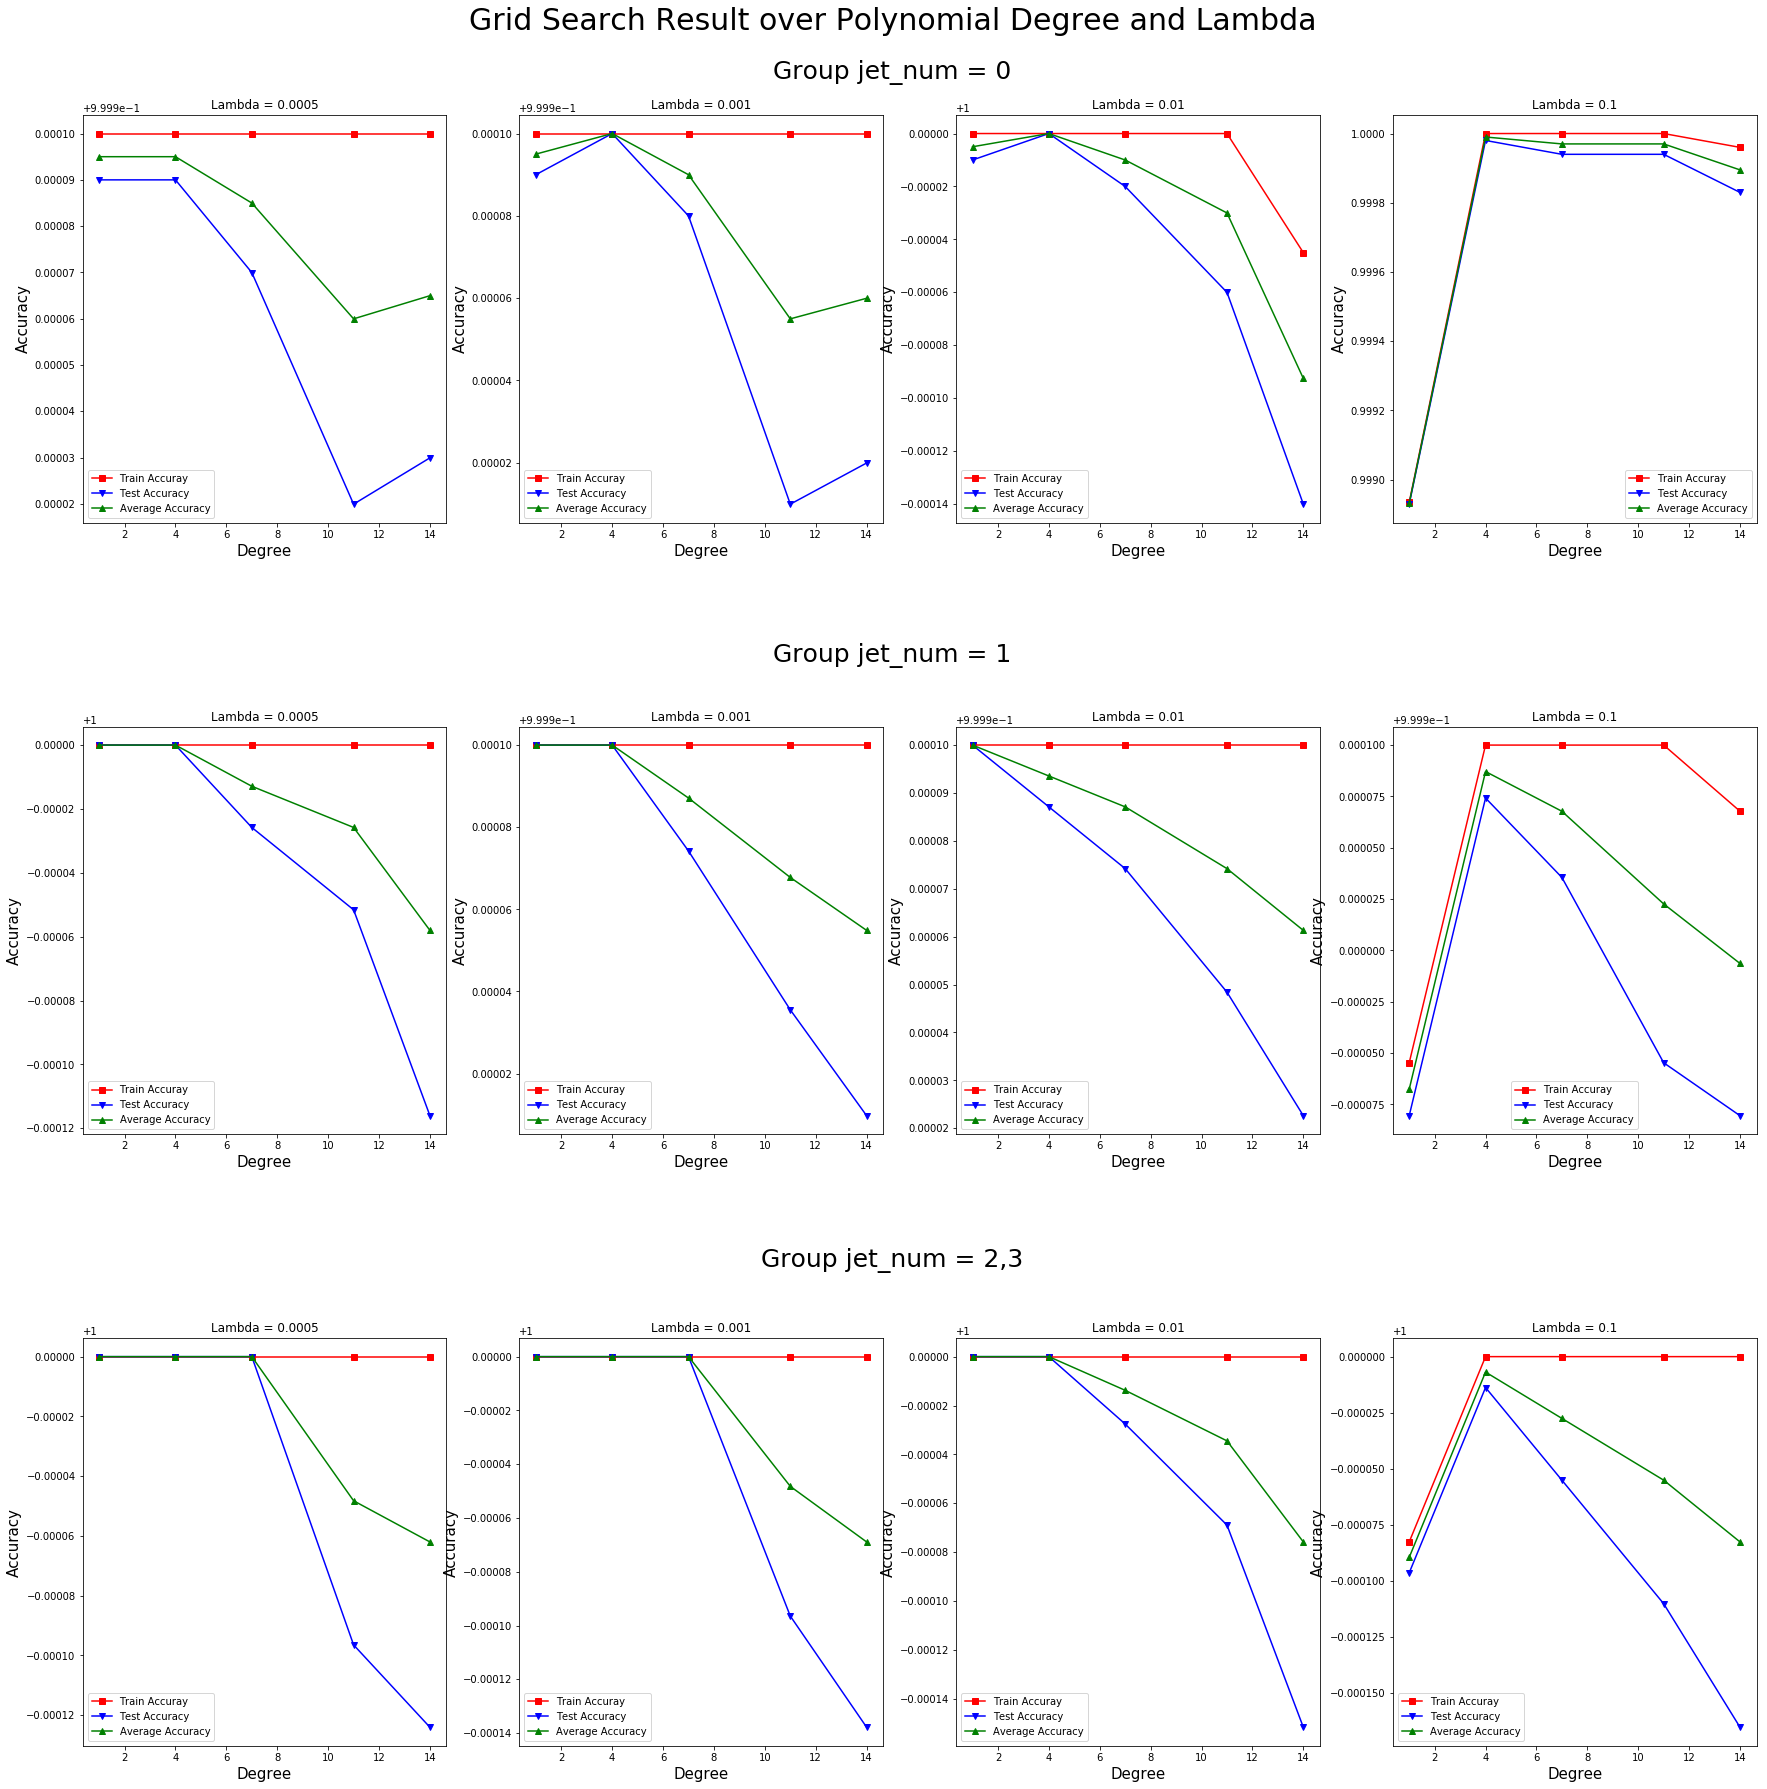

In [45]:
plot_gridsearch(acc_tr,acc_te,degrees,lambdas)

# Models Testing

In [ ]:
data_path_te = 'data/test.csv'
yb_te, data_te, idx_te, _ = load_csv_data(data_path_te, sub_sample=False)
data_te_dataframe = np.concatenate((yb_te.reshape([-1,1]), data_te), axis=1)
dataframe_te = DataFrame(data_te_dataframe, idx_tr.tolist(), labels_dataframe)

In [ ]:
# ridge_regression using crossv
w = []
acc_tr = []
acc_te = []
lambda_ = 0.0001
k_fold = 10
seed = 10

for i in range(len(dataframe_tr_grp)):
    x = dataframe_tr_grp[i].drop('Prediction').values
    x = log_process(x)
    x = build_polynomial_features(x,3)
    x_tr,_,_ = standardize(x)
    y_tr = (dataframe_tr_grp[i])['Prediction']
    w_tmp,acc_tr_tmp,acc_te_tmp = cv_loop(y_tr, x_tr,k_fold,seed,ridge_regression,lambda_=lambda_)
    w.append(w_tmp)
    acc_tr.append(acc_tr_tmp)
    acc_te.append(acc_te_tmp)

In [ ]:
acc_tr

In [ ]:
x =np.arange(10,20)
y =np.arange(20,30)
train_idx = list(set(np.arange(10))-set([1,2]))
test_idx = [1,2]
[x_train, y_train, x_test, y_test] = [x[train_idx], y[train_idx], x[test_idx], y[test_idx]]
x_train  
#     loss, weight = regression_method(y=y_train, tx=x_train, **kwargs)
    
#     y_train_pred = predict_labels(weight, x_train)
#     y_test_pred = predict_labels(weight, x_test)

#     accuracy_train = compute_accuracy(y_train_pred, y_train)
#     accuracy_test = compute_accuracy(y_test_pred, y_test)

#     return weight, accuracy_train, accuracy_test

In [ ]:
y_train

In [ ]:
set(np.arange(10))-set([1,2])

In [ ]:
type(np.sqrt(4))